# Importância de atributos e interpretação de modelos

Imagine que pretendemos criar um modelo para prever o preço de uma casa. Os valores que representam a localização da casa (bairro, cidade, país) certamente serão fatores mais importantes para determinar seu preço do que, por exemplo, se o piso da casa é de madeira ou não. 

De forma geral, se observa em modelos de aprendizado de máquina que algumas variáveis terão mais **importância** na predição de uma resposta do que outras. Alguns métodos estatísticos e de aprendizado de máquina nos permitem classificar variáveis como mais ou menos importantes. 

Vamos explorar alguns desses [métodos](https://machinelearningmastery.com/calculate-feature-importance-with-python/) considerando o conjunto de dados de Delaney (solubilidade). Você vai perceber que alguns desses métodos são os mesmos que foram explorados no Notebook sobre [seleção de variáveis](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Sele%C3%A7%C3%A3o%20de%20vari%C3%A1veis%20e%20Redu%C3%A7%C3%A3o%20de%20dimensionalidade.ipynb). Porém, quando fazemos seleção de variáveis, nosso objetivo é simplificar nosso modelo final, enquanto que, ao calcular a importância de variáveis, desejamos **interpretar** as predições do nosso modelo. De qualquer forma, não se esqueça de que também é possível usar métodos de importância para fazer seleção de variáveis.

### Definindo o conjunto de dados

In [1]:
import pandas as pd
df = pd.read_csv("Delaney_descriptors.csv", sep=";")

# Vamos selecionar apenas algumas colunas para possibilitar uma melhor visualização dos coeficientes
cols = ['FractionCSP3', 'HallKierAlpha', 'MaxEStateIndex', 'MinEStateIndex', 'MaxPartialCharge', 
        'MinPartialCharge', 'NumAliphaticRings', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 
        'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedHeterocycles', 'MolLogP', 'MolWt', 'ExactMolWt']

X = df[cols]
y = df.iloc[:, -1]  # resposta
cols = X.columns

Para que a escala não interfira nas medidas de importância, vamos padronizar os dados subtraindo a média e dividindo pelo desvio padrão.

**Importante**: lembre-se de que não é uma boa prática mudar a escala de todo um conjunto de dados para treinar modelos de aprendizado de máquina; o correto é separar o conjunto de teste antes de realizar a normalização, para evitar o que se denomina *data leakage*.

In [2]:
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=cols)

Finalmente, para podermos avaliar o efeito da presença de variáveis correlacionadas, vamos criar um segundo conjunto de dados sem variáveis colineares: `X_sem_colinearidade`.

In [3]:
# Verificando a existência de variáveis altamente correlacionadas
from itertools import combinations

corr_matrix = X.corr()
comb = combinations(corr_matrix.columns, 2)
for c1, c2 in comb:
    if abs(corr_matrix.loc[c1, c2]) > 0.8:
        print(f'r2 (módulo) entre as variáveis {c1} e {c2} = {corr_matrix.loc[c1, c2]:.3f}')

r2 (módulo) entre as variáveis MolWt e ExactMolWt = 1.000


In [4]:
# Vamos remover uma das variáveis correlacionadas
X_sem_colinearidade = X.drop(["ExactMolWt"], axis=1)

### 1. Coeficientes da regressão linear

Ao ajustarmos uma regressão linear aos dados, o modelo apresentará o seguinte formato: 

$Y = w_1×x_1 + w_2×x_2 + ... + w_n×x_n$

Em que w<sub>1</sub>...w<sub>n</sub> são os coeficientes da regressão linear. Contanto que os dados de entrada estejam em escalas comparáveis, os maiores coeficientes corresponderão às variáveis mais importantes para explicar o modelo. Note, porém, que somente a correlação *linear* entre as variáveis e a resposta é considerada, ou seja, uma variável que não é considerada importante por esse método, pode estar fortemente correlacionada com a resposta de uma forma *não-linear*.

In [5]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

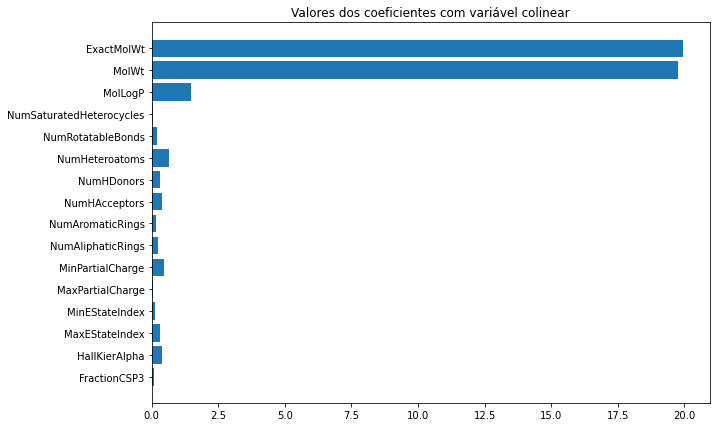

In [6]:
# Com variável colinear
reg = LinearRegression()
reg.fit(X, y)

importance = np.absolute(reg.coef_)

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Valores dos coeficientes com variável colinear")
plt.barh(cols, importance)
plt.show()

In [7]:
print("Coeficiente MolWt:", reg.coef_[-2])
print("Coeficiente ExactMolWt:", reg.coef_[-1])

Coeficiente MolWt: 19.74356909523021
Coeficiente ExactMolWt: -19.944463583074242


O tamanho da barra representa o valor do coeficiente (em módulo) para o modelo de regressão linear. Vemos que tanto `MolWt` como `ExactMolWt` recebem coeficientes elevados. Poderíamos imaginar que ambas as variáveis são muito importantes para descrever nossa resposta, mas veremos a seguir que isso não é verdade. Como os sinais dos coeficientes são opostos, o efeito de um cancela o do outro. Esse fenômeno é decorrente da colinearidade entre as variáveis. 

Portanto, antes de interpretar um modelo de regressão linear, verifique se os atributos são correlacionados entre si.

Vamos repetir a análise removendo os descritores colineares:

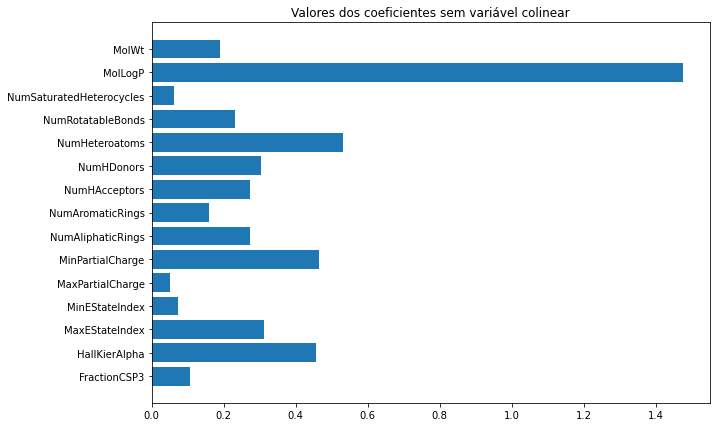

In [8]:
# Sem variável colinear
reg = LinearRegression()
reg.fit(X_sem_colinearidade, y)

importance = np.absolute(reg.coef_)

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Valores dos coeficientes sem variável colinear")
plt.barh(X_sem_colinearidade.columns, importance)
plt.show()

Vemos que, na verdade, `MolWt` não é tão importante quanto, por exemplo, `MolLogP` para descrever a solubilidade. Por outro lado, o descritor `NumSaturatedHeterocycles` (número de heterociclos saturados) tem contribuição muito pequena.

### 2. Coeficientes da regressão logística (classificação)

Em problemas de classificação, usamos a regressão logística em vez da linear para obter coeficientes que representam a importância das variáveis. Para transformar nosso problema de regressão para um de classificação, vamos verificar como é a distribuição da variável resposta.

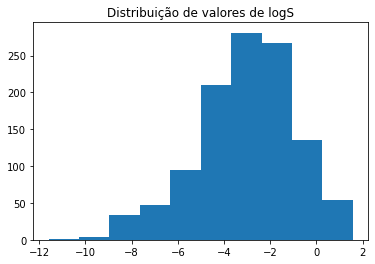

In [9]:
plt.hist(y)
plt.title("Distribuição de valores de logS")
plt.show()

Dada a distribuição, vamos usar o centro aproximado da distribuição como ponto de corte. Chamaremos de "solúveis" as moléculas com solubilidade menor que -3 (recebem o valor 1), e as outras, de "insolúveis" (recebem o valor 0).

In [10]:
# Convertendo o array para boolean: contém somente os valores True ou False dependendo da condição
y_bool = y > -3
# Convertendo os booleans a inteiros para poder treinar os modelos. True -> 1, False -> 0
y_clf = y_bool.astype('int8')
y_clf.value_counts()

1    582
0    546
Name: Solubilidade_medida, dtype: int64

Temos 582 "solúveis" e 546 "insolúveis". 

Agora, vamos ajustar uma regressão logística aos dados.

In [11]:
from sklearn.linear_model import LogisticRegression

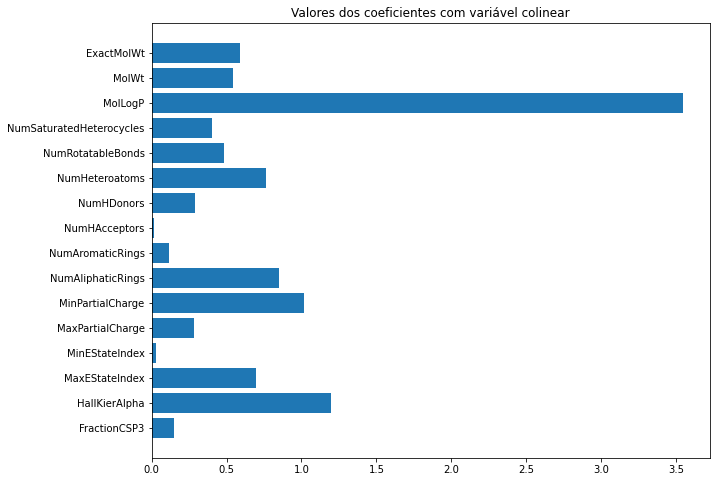

In [12]:
# Com variável colinear
logreg = LogisticRegression()
logreg.fit(X, y_clf)

importance = np.absolute(logreg.coef_[0])

# Gráfico da importância de atributos
plt.figure(figsize=(10,8))
plt.title("Valores dos coeficientes com variável colinear")
plt.barh(X.columns, importance)
plt.show()

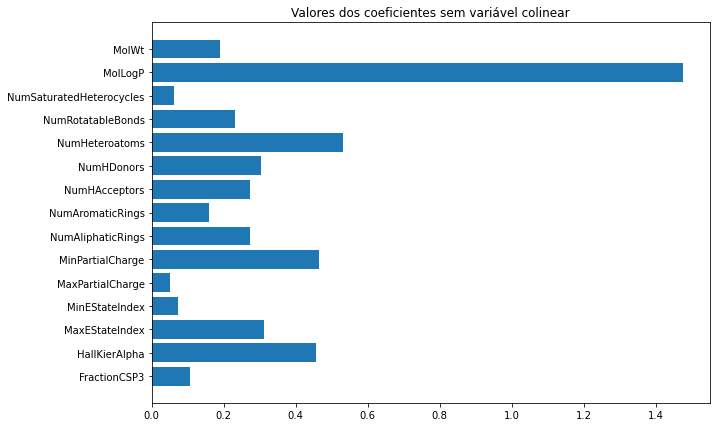

In [13]:
# Sem variável colinear
reg = LinearRegression()
reg.fit(X_sem_colinearidade, y)

importance = np.absolute(reg.coef_)

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Valores dos coeficientes sem variável colinear")
plt.barh(X_sem_colinearidade.columns, importance)
plt.show()

Os coeficientes parecem ser similares aos da regressão linear. Note que a importância do numero de aceptores de hidrogênio (`NumHAcceptors`) cai para praticamente zero. Podemos verificar a distribuição dessa variável nas duas classes:

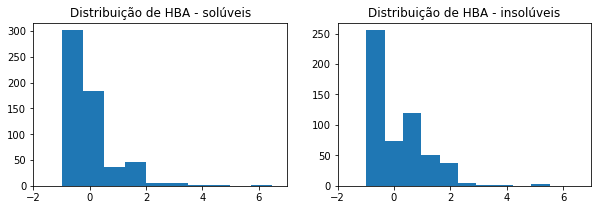

In [14]:
# Distribuição de HBA
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.xlim((-2,7))

# Usamos a Series y_bool, que contém os valores True/False, como mask
plt.hist(X[y_bool]["NumHAcceptors"])  # coluna "NumHAcceptors" do dataframe correspondente aos ativos
plt.title(f"Distribuição de HBA - solúveis")

plt.subplot(1, 2, 2)
plt.xlim((-2,7))
plt.hist(X[~y_bool]["NumHAcceptors"])  # coluna "NumHAcceptors" do dataframe correspondente aos inativos
plt.title(f"Distribuição de HBA - insolúveis")

plt.show()

Vemos que a distribuição desse descritor nas duas classes é parecida, ou seja, saber o número de aceptores de ligação de hidrogênio traz pouca informação a respeito da solubilidade. A situação deve ser diferente para `MolLogP`, que tem o maior coeficiente da regressão.

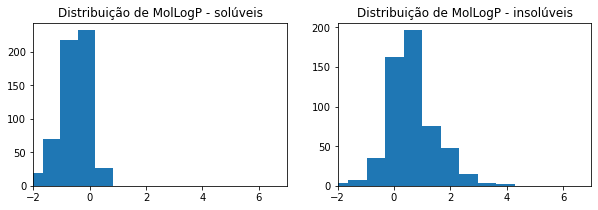

In [15]:
# Distribuição - MolLogP
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.xlim((-2,7))
plt.hist(X[y_bool]["MolLogP"])
plt.title(f"Distribuição de MolLogP - solúveis")

plt.subplot(1, 2, 2)
plt.xlim((-2,7))
plt.hist(X[~y_bool]["MolLogP"])
plt.title(f"Distribuição de MolLogP - insolúveis")

plt.show()

De fato, a maioria dos "solúveis" tem `MolLogP` < 0, e o contrário vale para os "insolúveis"

### 3. Floresta aleatória (*Random forest*)

Métodos baseados em árvores de decisão, como CART, RF e XGBoost calculam a importância de variáveis utilizando um termo denominado decréscimo médio da impureza (*mean decrease in impurity*), que mede o quanto a variável é eficaz em reduzir a variância (no caso de modelos de regressão) ou a incerteza (classificação).

In [16]:
from sklearn.ensemble import RandomForestRegressor

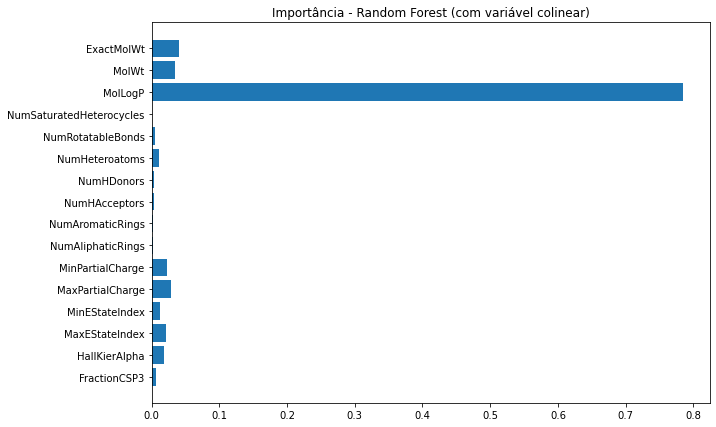

In [17]:
# Com variável colinear
reg = RandomForestRegressor()
reg.fit(X, y)

importance = reg.feature_importances_

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Importância - Random Forest (com variável colinear)")
plt.barh(X.columns, importance)
plt.show()

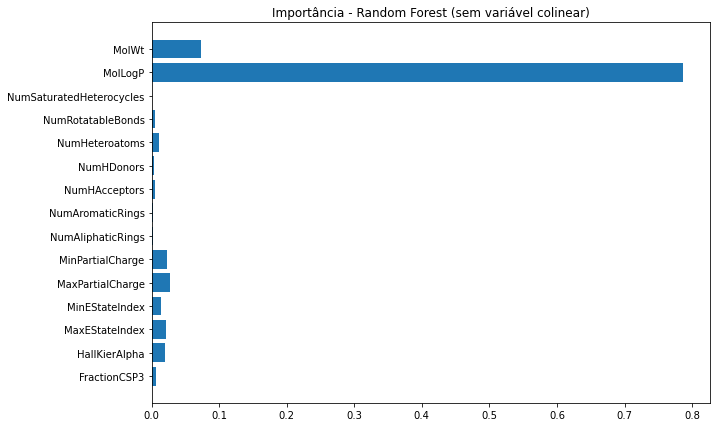

In [18]:
# Sem variável colinear
reg = RandomForestRegressor()
reg.fit(X_sem_colinearidade, y)

importance = reg.feature_importances_

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Importância - Random Forest (sem variável colinear)")
plt.barh(X_sem_colinearidade.columns, importance)
plt.show()

O modelo *Random Forest* reconhece a variável `MolLogP` como a mais importante para determinar o valor da solubilidade, e é menos sensível à presença de variáveis colineares. 

É possível fazer essa análise para o conjunto de dados de classificação, usando [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), mas os resultados podem ser diferentes da regressão. Isso porque o uso de *mean decrease in impurity* para estimar a importância das variáveis pode ser enviesado, conforme discutido nesse [link](https://explained.ai/rf-importance/), em inglês. Em resumo, os autores discutem os pontos negativos do cálculo da importância de variáveis utilizando *Random Forest* e sugerem o uso do método mostrado a seguir.

### 4. Permutação de variáveis (*Permutation importance*)

Nesse método, ajustamos um modelo a uma parte do conjunto de dados (treinamento) e usamos esse modelo para prever os valores da outra parte (validação). Em seguida, cada variável usada para ajustar o modelo é *aleatorizada*, removendo qualquer correlação que possa existir com a resposta, e um novo modelo é ajustado. Esse novo modelo, contendo uma das variáveis aleatorizada, é então usado para prever a resposta do conjunto de dados de validação. Esse processo pode ser repetido, por exemplo, usando validação cruzada, ou utilizando o mesmo conjunto de dados para treinamento e teste.

A ideia por trás desse método é que se a performance de um modelo cai significativamente quando aleatorizamos uma variável, essa variável é importante para descrever a resposta. Podemos aplicar a permutação de variáveis a qualquer modelo de aprendizado de máquina, sendo, de forma geral, um método robusto e confiável, contanto que o modelo tenha uma boa performance.

Um ponto importante a destacar é que a permutação de variáveis somente identifica a importância das variáveis para explicar o modelo. Portanto, se o modelo não for bom (baixa precisão/exatidão), a importância terá pouco ou nenhum valor prático. Por isso, é importante validar a performance do modelo (usando um conjunto de validação, ou validação cruzada) antes de calcular as importâncias.

Vamos usar *Random Forest* como modelo para podermos comparar esse método com o anterior, e verificar se ambos concordam.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

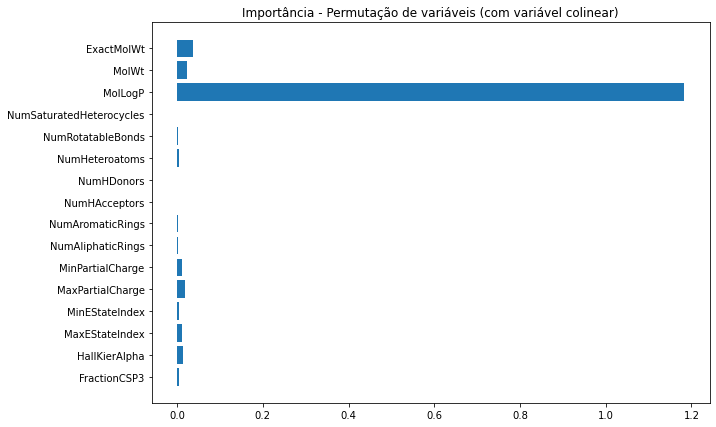

In [22]:
# Com variável colinear
# Separando os conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

# Ajustando o modelo e calculando o R² para o conjunto de validação
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
reg.score(X_val, y_val)

results = permutation_importance(reg, X_val, y_val, random_state=0)

importance = results.importances_mean

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Importância - Permutação de variáveis (com variável colinear)")
plt.barh(X.columns, importance)
plt.show()

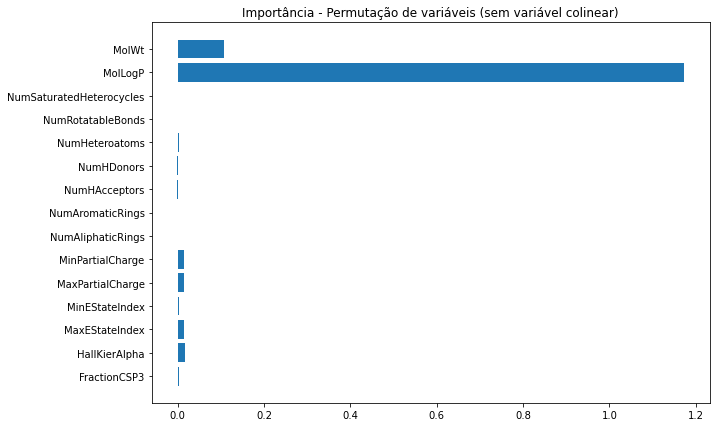

In [23]:
# Sem variável colinear
# Separando os conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_sem_colinearidade, y, random_state=0)

# Ajustando o modelo e calculando o R² para o conjunto de validação
reg = RandomForestRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.score(X_val, y_val)

results = permutation_importance(reg, X_val, y_val, random_state=0)

importance = results.importances_mean

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Importância - Permutação de variáveis (sem variável colinear)")
plt.barh(X_sem_colinearidade.columns, importance)
plt.show()

A documentação do scikit-learn mostra um [exemplo](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html) do uso de agrupamento hierárquico para lidar com variáveis correlacionadas.

No exemplo, é usado o coeficiente de correlação de [Spearman](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_postos_de_Spearman), que pode indicar correlação linear ou não-linear (indica se as variáveis estão monotonicamente relacionadas).

### 5. Informação mútua (*Mutual information*)

É um valor entre 0 e 1 que mede a dependência mútua entre duas variáveis. Quanto mais próximo de 1, maior a dependência entre as variáveis, ou seja, se estivermos comparando a variável resposta com algum atributo, um valor alto de MI indica que o atributo é importante para explicar a resposta. Essa medida também pode ser utilizada para remover variáveis redundantes (correlacionadas) antes de treinar um modelo de ML. Nesse caso, comparamos os atributos entre si, e não com a resposta.

[Wikipedia - Informação mútua](https://pt.wikipedia.org/wiki/Informa%C3%A7%C3%A3o_m%C3%BAtua)</br>
[Exemplo - Scikit-learn](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py)

In [24]:
from sklearn.feature_selection import mutual_info_regression

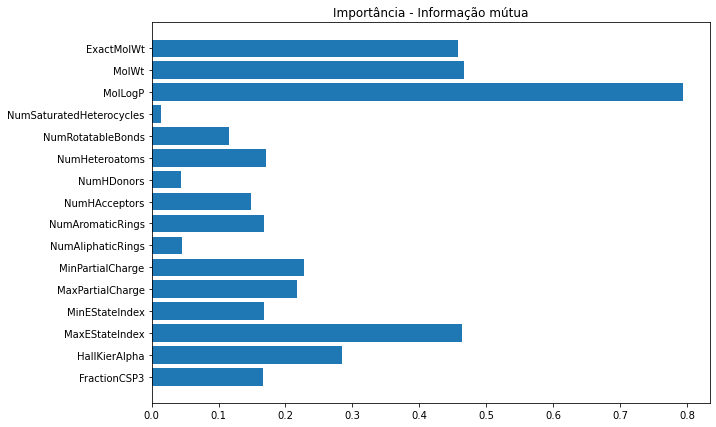

In [25]:
# Com variável colinear
mi = mutual_info_regression(X, y)

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Importância - Informação mútua")
plt.barh(X.columns, mi)
plt.show()

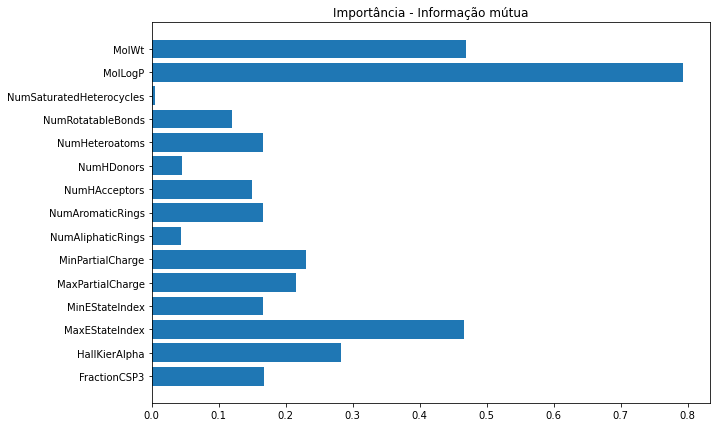

In [26]:
# Sem variável colinear
mi = mutual_info_regression(X_sem_colinearidade, y)

# Gráfico da importância de atributos
plt.figure(figsize=(10,7))
plt.title("Importância - Informação mútua")
plt.barh(X_sem_colinearidade.columns, mi)
plt.show()

De forma similar, `MolLogP` se mantém como a variável mais importante, seguida por `MolWt` e `MaxEStateIndex`

### 6. Valores de Shapley (*Shapley values*)

Finalmente, vamos abordar um método amplamente utilizado, derivado da teoria dos jogos. De forma simplificada, os valores de Shapley indicam o quanto cada variável contribui para "desviar" o valor da resposta. 

Por exemplo, vimos que `MolLogP` costuma ser identificado como um descritor importante, e o número de anéis aromáticos, é menos importante. Portanto, se estamos tentando prever a solubilidade, podemos imaginar que nossa predição começa com um "valor base" de -3. Se o modelo verifica, por exemplo, que o o valor de MolLogP é -1 (associado a compostos mais solúveis), podemos imaginar que o valor base seria deslocado em -3 unidades. Já o número de anéis aromáticos terá pouco efeito, e deslocará o valor em +0,01. Portanto, se somente essas duas variáveis fossem usadas, o valor final da predição do modelo seria (-3) + (-3) + (+0,01) = -5,99.

Assim, como `MolLogP` "desvia" o valor-base em mais unidades que o número de anéis aromáticos (e isso é válido para todas as amostras), ele terá um valor de Shapley maior.

No Python, podemos instalar o pacote `shap` para calcular os Shapley values, ou utilizar a implementação do pacote `pycaret`, abordado em outro Notebook.

[Download shap](https://github.com/slundberg/shap) </br>
[Download pycaret](https://pycaret.readthedocs.io/en/latest/installation.html) </br>
[Documentação shap](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html) </br>
[pycaret - Feature importance](https://pycaret.org/feature-importance/)

In [27]:
import shap

In [29]:
# Criar modelo
reg = RandomForestRegressor(random_state=0)
reg.fit(X_train, y_train)

# Explicações usando Shapley values
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_val)

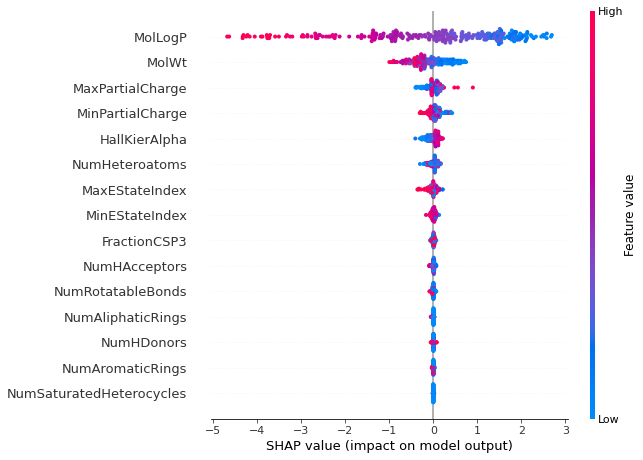

In [30]:
# Resultados considerando todas as amostras
shap.summary_plot(shap_values, X_val)

Como interpretar esse gráfico: os pontos cor de rosa indicam um valor elevado do descritor indicado à esquerda, enquanto os azuis representam valores baixos. Vemos para `MolLogP` que compostos com valor alto tendem a ficar à esquerda do gráfico, e possuem um valor SHAP negativo, ou seja, compostos com `MolLogP` alto tendem a diminuir o valor do log da solubilidade (consequentemente, indicam menor solubilidade).

Isso também pode ser visto em um gráfico de dependência, mostrado abaixo. Podemos ignorar a cor (selecionada automaticamente pelo módulo shap) e verificarmos apenas os eixos x e y: notamos que valores menores de `MolLogP` estão associados a SHAP values positivos (aumentam o valor da predição), seguindo uma curva descendente, com compostos muito lipofílicos apresentando efeito negativo na solubilidade.

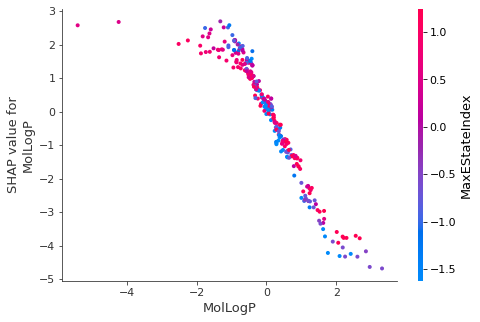

In [34]:
shap.dependence_plot("MolLogP", shap_values, X_val)

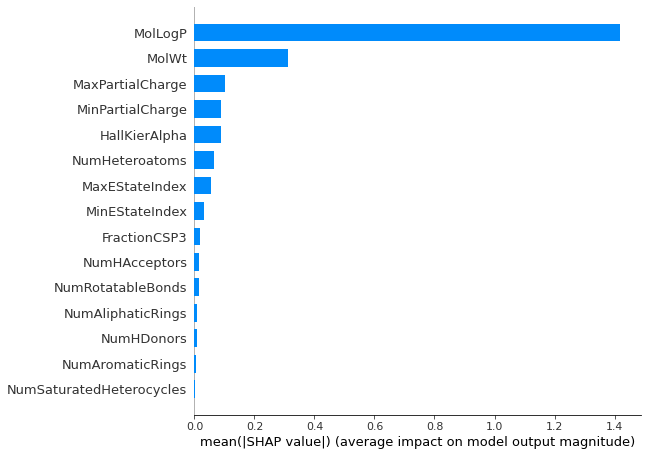

In [31]:
# Como gráfico de barras, similar aos mostrados anteriormente
shap.summary_plot(shap_values, X_val, plot_type='bar')

É possível também visualizar a interação entre duas variáveis. Interação é o fenômeno que, por exemplo, faz com que duas amostras com o mesmo valor de `MolLogP` tenham solubilidades diferentes - uma delas pode ter um valor mais favorável de outro descritor. É por isso que nem sempre o aumento no valor de uma variável terá o mesmo efeito para todas as amostras.

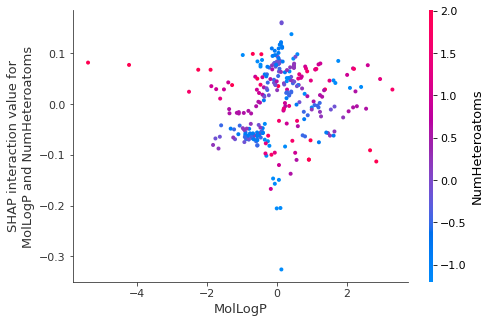

In [33]:
# Interação entre MolLogP e NumHeteroatoms
shap_interaction_values = explainer.shap_interaction_values(X_val)

shap.dependence_plot(
    ("MolLogP", "NumHeteroatoms"),
    shap_interaction_values, X_val)

Nesse caso, não é possível perceber qualquer interação entre `MolLogP` e `NumHeteroatoms`. Caso houvesse interação, o gráfico seria uma curva bem definida.

## Conclusão

Modelos que não podem ser explicados, por mais precisos que sejam, dificilmente serão aceitos para aplicações importantes. Nesse contexto, métodos de importância de atributos são essenciais pois permitem explicar as predições de modelos de aprendizado de máquina, indicando quais descritores fornecidos são mais importantes para determinar o valor da predição.

Nesse Notebook, foram apresentados seis métodos para determinação de importância, sendo os métodos apresentados nos itens 4 e 6 os mais utilizados atualmente, podendo ser empregados para qualquer modelo de aprendizado de máquina.